Mounted at /content/drive


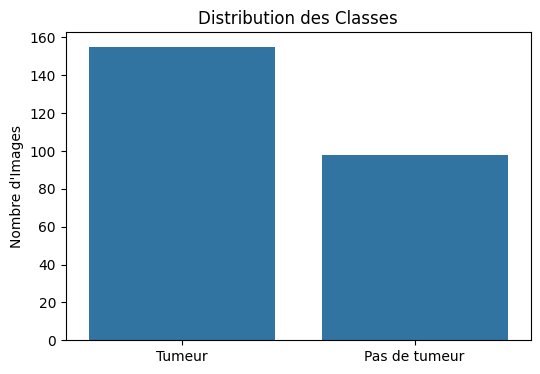

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


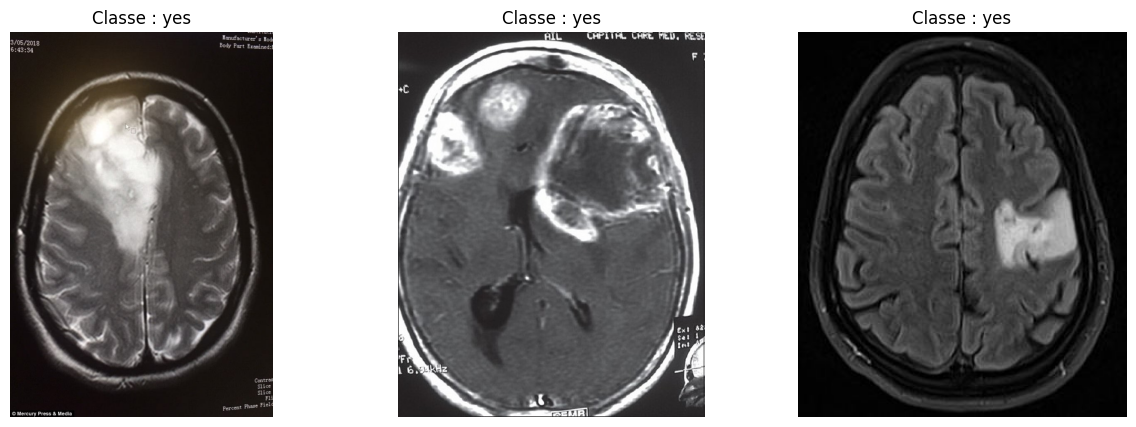

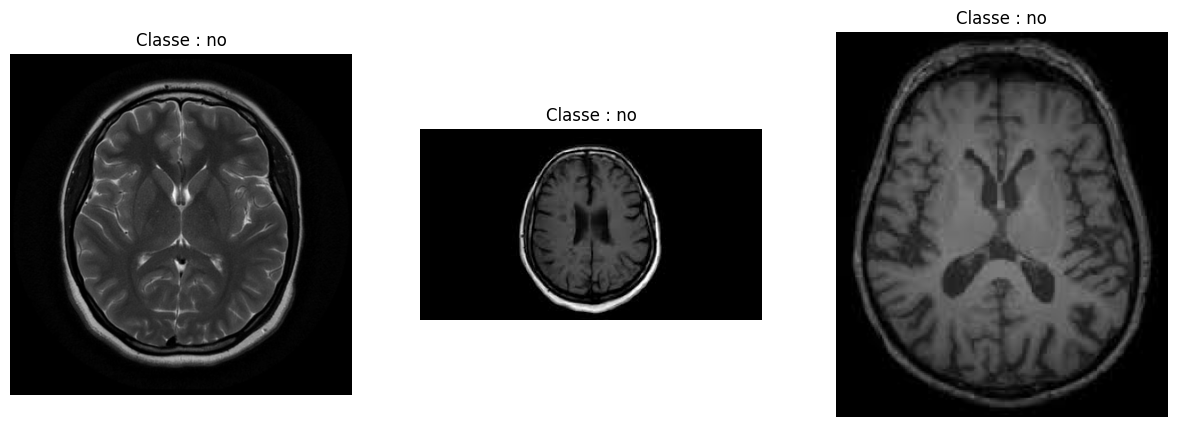

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.5147 - loss: 3.1310 - val_accuracy: 0.6863 - val_loss: 2.7486
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.4342 - loss: 2.7200 - val_accuracy: 0.3922 - val_loss: 2.4060
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.4431 - loss: 2.3320 - val_accuracy: 0.6863 - val_loss: 2.0236
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6246 - loss: 1.9725 - val_accuracy: 0.6275 - val_loss: 1.7307
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.5421 - loss: 1.7589 - val_accuracy: 0.7647 - val_loss: 1.5172
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6126 - loss: 1.5155 - val_accuracy: 0.7451 - val_loss: 1.3309
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.6702 - loss: 1.3233 - val_accuracy: 0.8235 - val_loss: 1.1783
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6501 - loss: 1.2056 - val_accuracy: 0.8039 - val_loss: 1.0723
Epoch 9/

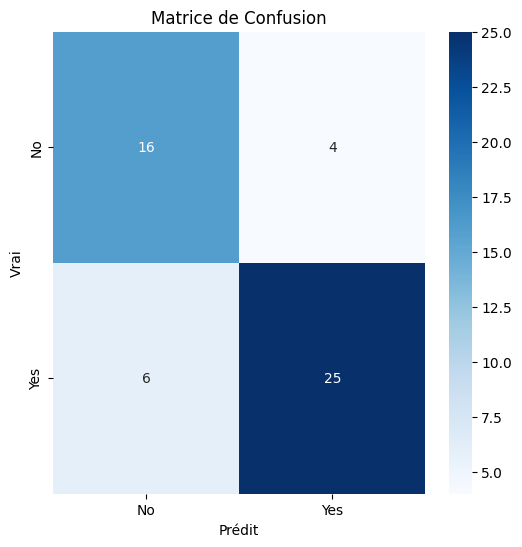

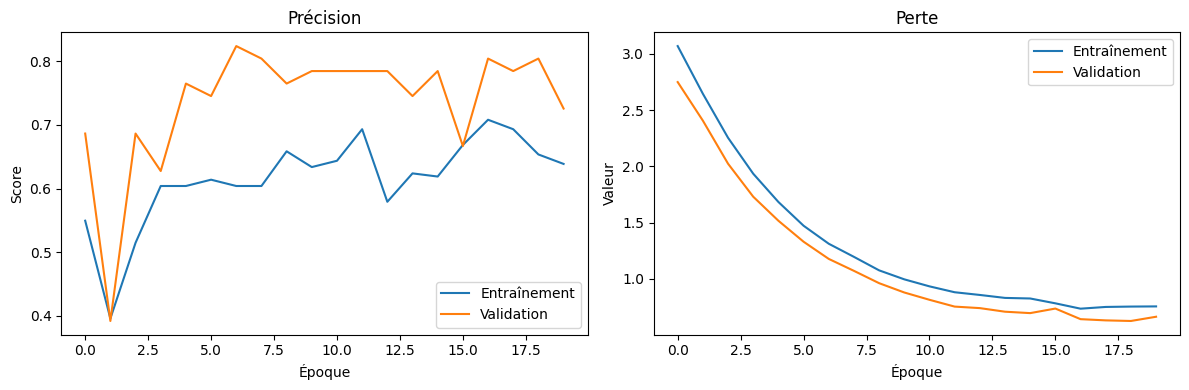

In [ ]:

# 1. Importation des bibliothèques
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the CIC-DDoS2019 dataset
data_path = '/content/drive/MyDrive/brain_tumor_dataset'

# 3. Définition des chemins
base_dir = data_path
yes_dir = os.path.join(base_dir, 'yes')
no_dir = os.path.join(base_dir, 'no')

if not os.path.exists(yes_dir) or not os.path.exists(no_dir):
    raise FileNotFoundError("Répertoire des images manquant.")

num_yes = len(os.listdir(yes_dir))
num_no = len(os.listdir(no_dir))

plt.figure(figsize=(6, 4))
sns.barplot(x=['Tumeur', 'Pas de tumeur'], y=[num_yes, num_no])
plt.title('Distribution des Classes')
plt.ylabel('Nombre d\'Images')
plt.show()

# 4. Préparation des données
img_width, img_height = 224, 224
data = [{'image_path': os.path.join(folder, file), 'label': label}
        for label, folder in [('yes', yes_dir), ('no', no_dir)]
        for file in os.listdir(folder)]
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 29
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    workers=4
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
    workers=4
)

y_train = train_df['label'].map({'yes': 1, 'no': 0}).values
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# 5. Affichage des images
def show_samples(class_name, num_samples=3):
    folder = yes_dir if class_name == 'yes' else no_dir
    images = os.listdir(folder)[:num_samples]
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(images):
        img_path = os.path.join(folder, image_name)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Classe : {class_name}")
        plt.axis('off')
    plt.show()

show_samples('yes')
show_samples('no')

# 6. Définition du modèle
def create_model_head():
    model = Sequential([
        Input(shape=(img_width, img_height, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

model = create_model_head()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 7. Entraînement
callbacks = [
    EarlyStopping(patience=2, restore_best_weights=True, verbose=1),
]

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# 8. Évaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"Précision de Test : {test_acc*100:.2f}%")

y_pred = (model.predict(test_generator, verbose=0) > 0.5).astype(int)
y_true = test_df['label'].map({'yes': 1, 'no': 0}).values

print("\nRapport de Classification :")
print(classification_report(y_true, y_pred, target_names=['No', 'Yes']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de Confusion')
plt.show()

# 9. Historique
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision')
plt.xlabel('Époque')
plt.ylabel('Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte')
plt.xlabel('Époque')
plt.ylabel('Valeur')
plt.legend()
plt.tight_layout()
plt.show()